In [1]:
# --- Imports & Config ---
import os, re, gc, json
import numpy as np
import pandas as pd
from pathlib import Path
from joblib import dump, load

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    roc_auc_score, average_precision_score, accuracy_score, f1_score,
    classification_report, confusion_matrix, precision_recall_curve
)
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.utils.class_weight import compute_class_weight

# Path to your Kaggle CSV directory (MIMIC-III demo/mirror with lowercase headers).
DATA_DIR = "/home/sraja/.cache/kagglehub/datasets/asjad99/mimiciii/versions/1/mimic-iii-clinical-database-demo-1.4"  # <<< EDIT THIS

# Core settings
HOURS_WINDOW = 6
CHUNK_SIZE   = 2_000_000  # tune for your RAM

# Optional feature blocks
ENABLE_LABS = True   # set True to add LABEVENTS aggregates
ENABLE_GCS  = True   # set True to add GCS aggregates from CHARTEVENTS via D_ITEMS

# Known ITEMIDs (CareVue & MetaVision) for vitals; will be extended via D_ITEMS if present
KNOWN_ITEM_MAP = {
    "hr":       [211, 220045],
    "sysbp":    [51, 220179],
    "diabp":    [8368, 220180],
    "meanbp":   [52, 220181],
    "resprate": [618, 220210],
    "spo2":     [220277],
    "tempc":    [676, 223761],
}

def ensure_dir(p):
    Path(p).mkdir(parents=True, exist_ok=True)
ensure_dir("models")


In [2]:
# --- Helper functions ---
def normalize_cols(df: pd.DataFrame) -> pd.DataFrame:
    df.columns = [c.lower() for c in df.columns]
    return df

def safe_read_csv(data_dir, name, usecols=None, dtype=None):
    path = os.path.join(data_dir, name)
    df = pd.read_csv(path, dtype=dtype, low_memory=False)
    df = normalize_cols(df)
    if usecols:
        df = df[[c for c in [u.lower() for u in usecols] if c in df.columns]]
    return df

def is_stroke_icd9(code: str) -> bool:
    if code is None: return False
    c = re.sub(r"[^0-9]", "", str(code))
    if c.startswith(("430", "431", "432")):  # hemorrhagic incl. SAH
        return True
    if len(c) >= 3 and (c.startswith("433") or c.startswith("434")):
        return c.endswith("1")              # infarction present
    return False

def build_item_map(d_items_df: pd.DataFrame | None, base_map: dict) -> dict:
    item_map = {k: set(v) for k, v in base_map.items()}
    if d_items_df is None or "label" not in d_items_df.columns:
        return {k: sorted(v) for k, v in item_map.items()}
    di = d_items_df.copy()
    di["label_l"] = di["label"].str.lower()

    ITEM_KEYWORDS = {
        "hr":       ["heart rate"],
        "sysbp":    ["non invasive systolic", "systolic blood pressure"],
        "diabp":    ["non invasive diastolic", "diastolic blood pressure"],
        "meanbp":   ["non invasive mean", "mean blood pressure"],
        "resprate": ["respiratory rate"],
        "spo2":     ["spo2", "oxygen saturation"],
        "tempc":    ["temperature c", "temperature celsius", "temperature f"],
    }
    for var, kws in ITEM_KEYWORDS.items():
        for kw in kws:
            m = di[di["label_l"].str.contains(kw, na=False)]
            for iid in m["itemid"].tolist():
                item_map[var].add(int(iid))
    return {k: sorted(v) for k, v in item_map.items()}

def normalize_temp_to_c(values, uoms):
    vals = values.copy()
    if uoms is None: return vals
    mask_f = uoms.astype(str).str.contains("f", case=False, na=False)
    vals.loc[mask_f] = (vals.loc[mask_f] - 32.0) * (5.0/9.0)
    return vals

def aggregate_first6h_vitals(vitals_chunk, icu_df, item_map):
    merged = vitals_chunk.merge(
        icu_df[["icustay_id","hadm_id","intime"]],
        on="icustay_id",
        how="inner",
        suffixes=("", "_icu")
    )
    # Ensure single hadm_id
    if "hadm_id" not in merged.columns:
        if "hadm_id_icu" in merged.columns:
            merged["hadm_id"] = merged["hadm_id_icu"]
        elif "hadm_id_x" in merged.columns or "hadm_id_y" in merged.columns:
            merged["hadm_id"] = merged.get("hadm_id_x", merged.get("hadm_id_y"))

    merged["charttime"] = pd.to_datetime(merged["charttime"])
    merged["intime"]    = pd.to_datetime(merged["intime"])
    merged["hours_since_intime"] = (merged["charttime"] - merged["intime"]).dt.total_seconds()/3600.0
    merged = merged[(merged["hours_since_intime"] >= 0) & (merged["hours_since_intime"] <= HOURS_WINDOW)]

    # Map ITEMID → item
    inv = {}
    for name, ids in item_map.items():
        for iid in ids:
            inv[int(iid)] = name
    merged["item"] = merged["itemid"].map(inv)

    merged = merged.dropna(subset=["item","valuenum"]).copy()
    merged["valuenum"] = pd.to_numeric(merged["valuenum"], errors="coerce")
    merged = merged.dropna(subset=["valuenum"])

    if "valueuom" in merged.columns:
        tmask = merged["item"].eq("tempc")
        if tmask.any():
            merged.loc[tmask, "valuenum"] = normalize_temp_to_c(merged.loc[tmask, "valuenum"], merged.loc[tmask, "valueuom"])

    def agg_one(df):
        df = df.sort_values("charttime")
        vals = df["valuenum"].values.astype(float)
        times = df["hours_since_intime"].values
        res = {
            "mean": float(np.mean(vals)),
            "min":  float(np.min(vals)),
            "max":  float(np.max(vals)),
            "std":  float(np.std(vals)) if vals.size > 1 else 0.0,
            "last": float(vals[-1]),
            "slope": 0.0
        }
        if vals.size >= 2 and (times[-1]-times[0]) > 0:
            res["slope"] = float((vals[-1] - vals[0]) / (times[-1] - times[0]))
        return pd.Series(res)

    if merged.empty:
        return pd.DataFrame(columns=["hadm_id"])

    agg = merged.groupby(["hadm_id","item"], as_index=True).apply(agg_one)
    wide = agg.unstack("item")
    wide.columns = [f"{stat}_{item}" for stat, item in wide.columns]
    wide = wide.reset_index()
    return wide

In [3]:

# --- Load base tables (lowercase columns) ---
print("Loading ADMISSIONS, ICUSTAYS, DIAGNOSES_ICD, D_ITEMS ...")
adm  = safe_read_csv(DATA_DIR, "ADMISSIONS.csv",   usecols=["subject_id","hadm_id"])
icu  = safe_read_csv(DATA_DIR, "ICUSTAYS.csv",     usecols=["icustay_id","hadm_id","intime"])
diag = safe_read_csv(DATA_DIR, "DIAGNOSES_ICD.csv",usecols=["subject_id","hadm_id","icd9_code"])

# optional D_ITEMS
try:
    d_items = safe_read_csv(DATA_DIR, "D_ITEMS.csv", usecols=["itemid","label","dbsource"])
except Exception:
    d_items = None

# stroke labels by hadm_id
diag["label"] = diag["icd9_code"].apply(is_stroke_icd9)
labels = diag.groupby("hadm_id", as_index=False)["label"].max()
print("Labels:", labels["label"].value_counts(dropna=False).to_dict())

# Build item map (extend known ids using D_ITEMS labels if available)
item_map = build_item_map(d_items, KNOWN_ITEM_MAP)
all_itemids = sorted({iid for ids in item_map.values() for iid in ids})
print("Item map (first few):", {k: (list(v)[:5] + (['...'] if len(v) > 5 else [])) for k, v in item_map.items()})


Loading ADMISSIONS, ICUSTAYS, DIAGNOSES_ICD, D_ITEMS ...
Labels: {False: 123, True: 6}
Item map (first few): {'hr': [211, 3494, 220045, 220046, 220047], 'sysbp': [51, 220179], 'diabp': [8368, 220180], 'meanbp': [52, 220181], 'resprate': [618, 619, 220210, 224688, 224689, '...'], 'spo2': [646, 5820, 6719, 8554, 220277, '...'], 'tempc': [676, 677, 678, 679, 223761, '...']}


In [4]:
# --- Extract vitals from CHARTEVENTS (chunked) ---
chartevents_path = os.path.join(DATA_DIR, "CHARTEVENTS.csv")
usecols = ["row_id","subject_id","hadm_id","icustay_id","charttime","itemid","valuenum","valueuom"]

features_wide_list = []
print("Scanning CHARTEVENTS.csv in chunks ...")
chunk_iter = pd.read_csv(chartevents_path, usecols=usecols, chunksize=CHUNK_SIZE,
                         dtype={"itemid":"int32","icustay_id":"float64"}, low_memory=True)
for i, chunk in enumerate(chunk_iter, 1):
    chunk = normalize_cols(chunk)
    chunk = chunk[chunk["itemid"].isin(all_itemids)]
    chunk = chunk.dropna(subset=["icustay_id","hadm_id"])
    if chunk.empty:
        continue
    chunk["icustay_id"] = chunk["icustay_id"].astype(int)

    wide = aggregate_first6h_vitals(chunk, icu, item_map)
    if not wide.empty:
        features_wide_list.append(wide)

    del chunk, wide
    if i % 5 == 0:
        print(f" processed {i} chunks ...")
        gc.collect()

if not features_wide_list:
    raise RuntimeError("No vitals found for selected ITEMIDs; check DATA_DIR and item_map.")
features_wide = pd.concat(features_wide_list, ignore_index=True).sort_values("hadm_id").drop_duplicates(subset=["hadm_id"], keep="last")
print("Vitals wide shape:", features_wide.shape)


Scanning CHARTEVENTS.csv in chunks ...


/tmp/ipykernel_20280/77953074.py:9: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(chunk_iter, 1):
/tmp/ipykernel_20280/2696766035.py:107: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  agg = merged.groupby(["hadm_id","item"], as_index=True).apply(agg_one)


Vitals wide shape: (125, 43)


In [5]:
# --- (Optional) Add LABEVENTS aggregates in first 6h ---
if ENABLE_LABS:
    def safe_read_csv_lower(path, usecols=None, dtype=None):
        df = pd.read_csv(path, dtype=dtype, low_memory=False)
        df = normalize_cols(df)
        if usecols:
            keep = [c for c in usecols if c in df.columns]
            df = df[keep]
        return df

    labs_path = os.path.join(DATA_DIR, "LABEVENTS.csv")
    if os.path.exists(labs_path):
        labs = safe_read_csv_lower(labs_path, usecols=["subject_id","hadm_id","itemid","charttime","valuenum","valueuom"])
        labs = labs.dropna(subset=["hadm_id","valuenum"]).copy()
        # Join ICU intime (by hadm_id) to compute window
        icu_unique = icu[["hadm_id","intime"]].drop_duplicates("hadm_id")
        labs = labs.merge(icu_unique, on="hadm_id", how="left")
        labs["charttime"] = pd.to_datetime(labs["charttime"])
        labs["intime"]    = pd.to_datetime(labs["intime"])
        labs["h"] = (labs["charttime"] - labs["intime"]).dt.total_seconds()/3600.0
        labs = labs[(labs["h"]>=0) & (labs["h"]<=HOURS_WINDOW)]
        labs["valuenum"] = pd.to_numeric(labs["valuenum"], errors="coerce")
        labs = labs.dropna(subset=["valuenum"])

        def agg_lab(df):
            df = df.sort_values("charttime")
            v = df["valuenum"].values
            t = df["h"].values
            out = {
                "lab_mean": float(np.mean(v)),
                "lab_min":  float(np.min(v)),
                "lab_max":  float(np.max(v)),
                "lab_std":  float(np.std(v)) if v.size > 1 else 0.0,
                "lab_last": float(v[-1]),
                "lab_slope": 0.0
            }
            if v.size >= 2 and (t[-1]-t[0]) > 0:
                out["lab_slope"] = float((v[-1]-v[0])/(t[-1]-t[0]))
            return pd.Series(out)

        lab_wide = labs.groupby(["hadm_id","itemid"], as_index=True).apply(agg_lab).unstack("itemid")
        lab_wide.columns = [f"{stat}_lab_{itemid}" for stat, itemid in lab_wide.columns]
        lab_wide = lab_wide.reset_index()
        features_wide = features_wide.merge(lab_wide, on="hadm_id", how="left")
        print("After labs →", features_wide.shape)
    else:
        print("LABEVENTS.csv not found — skipping.")


After labs → (125, 727)


/tmp/ipykernel_20280/2207131375.py:41: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  lab_wide = labs.groupby(["hadm_id","itemid"], as_index=True).apply(agg_lab).unstack("itemid")


In [6]:
if ENABLE_GCS:
    d_items_path = os.path.join(DATA_DIR, "D_ITEMS.csv")
    if os.path.exists(d_items_path):
        di = pd.read_csv(d_items_path, low_memory=False)
        di = normalize_cols(di)
        di["label_l"] = di["label"].str.lower()

        def find_ids(kws):
            m = di[di["label_l"].str.contains("|".join([re.escape(k) for k in kws]), na=False)]
            return sorted(set(m["itemid"].astype(int).tolist()))

        ids_gcs_total = find_ids(["glasgow coma scale total","gcs total","gcs - total"])
        ids_gcs_eye   = find_ids(["glasgow coma scale eye","gcs eye","gcs - eye opening"])
        ids_gcs_verbal= find_ids(["glasgow coma scale verbal","gcs verbal","gcs - verbal response"])
        ids_gcs_motor = find_ids(["glasgow coma scale motor","gcs motor","gcs - motor response"])
        gcs_ids_all = set(ids_gcs_total + ids_gcs_eye + ids_gcs_verbal + ids_gcs_motor)

        usecols_gcs = ["subject_id","hadm_id","icustay_id","charttime","itemid","valuenum"]
        gcs_parts = []
        chunk_iter = pd.read_csv(os.path.join(DATA_DIR,"CHARTEVENTS.csv"),
                                 usecols=usecols_gcs, chunksize=CHUNK_SIZE, low_memory=True)
        for ch in chunk_iter:
            ch = normalize_cols(ch)
            ch = ch[ch["itemid"].isin(gcs_ids_all)]
            if ch.empty:
                continue

            # merge ICU to get intime (and a reliable hadm_id to fall back to)
            ch = ch.merge(
                icu[["icustay_id","hadm_id","intime"]],
                on="icustay_id",
                how="inner",
                suffixes=("", "_icu")
            )

            # --- Ensure a single 'hadm_id' column exists
            if "hadm_id" not in ch.columns:
                if "hadm_id_icu" in ch.columns:
                    ch["hadm_id"] = ch["hadm_id_icu"]
                elif "hadm_id_x" in ch.columns or "hadm_id_y" in ch.columns:
                    ch["hadm_id"] = ch.get("hadm_id_x", ch.get("hadm_id_y"))

            # if still missing hadm_id, derive it via icustay_id join (extreme fallback)
            if "hadm_id" not in ch.columns or ch["hadm_id"].isna().all():
                ch = ch.merge(
                    icu[["icustay_id","hadm_id"]].drop_duplicates("icustay_id"),
                    on="icustay_id",
                    how="left",
                    suffixes=("", "_fromicu")
                )
                if "hadm_id_fromicu" in ch.columns:
                    ch["hadm_id"] = ch["hadm_id"].fillna(ch["hadm_id_fromicu"])
                    ch.drop(columns=["hadm_id_fromicu"], inplace=True)

            # time window
            ch["charttime"] = pd.to_datetime(ch["charttime"])
            ch["intime"]    = pd.to_datetime(ch["intime"])
            ch["h"] = (ch["charttime"] - ch["intime"]).dt.total_seconds()/3600.0
            ch = ch[(ch["h"]>=0) & (ch["h"]<=HOURS_WINDOW)]

            # clean values & keep rows with hadm_id
            ch["valuenum"] = pd.to_numeric(ch["valuenum"], errors="coerce")
            ch = ch.dropna(subset=["valuenum","hadm_id"])

            gcs_parts.append(ch)

        if gcs_parts:
            gcs_long = pd.concat(gcs_parts, ignore_index=True)

            def comp_of(i):
                i = int(i)
                if i in ids_gcs_total: return "gcs_total"
                if i in ids_gcs_eye:   return "gcs_eye"
                if i in ids_gcs_verbal:return "gcs_verbal"
                if i in ids_gcs_motor: return "gcs_motor"
                return None

            gcs_long["comp"] = gcs_long["itemid"].map(comp_of)
            gcs_long = gcs_long.dropna(subset=["comp"])

            def agg_gcs(df):
                df = df.sort_values("charttime")
                v = df["valuenum"].values
                return pd.Series({
                    "mean": float(np.mean(v)),
                    "min":  float(np.min(v)),
                    "max":  float(np.max(v)),
                    "last": float(v[-1]),
                })

            # <-- this was failing before because 'hadm_id' didn't exist -->
            gcs_wide = gcs_long.groupby(["hadm_id","comp"]).apply(agg_gcs).unstack("comp")
            gcs_wide.columns = [f"gcs_{stat}_{comp}" for stat, comp in gcs_wide.columns]
            gcs_wide = gcs_wide.reset_index()

            features_wide = features_wide.merge(gcs_wide, on="hadm_id", how="left")
            print("After GCS →", features_wide.shape)
        else:
            print("No GCS rows found — check D_ITEMS keywords.")
    else:
        print("D_ITEMS.csv not found — skipping GCS.")

After GCS → (125, 743)


/tmp/ipykernel_20280/2994946822.py:92: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gcs_wide = gcs_long.groupby(["hadm_id","comp"]).apply(agg_gcs).unstack("comp")


In [7]:
# --- Build ML dataset (merge labels + subject ids) ---
dataset = features_wide.merge(labels, on="hadm_id", how="inner")
dataset = dataset.merge(adm, on="hadm_id", how="left")  # adds subject_id
dataset = dataset.dropna(subset=["label"]).copy()
dataset["label"] = dataset["label"].astype(int)
print("Dataset shape:", dataset.shape, "positives:", int(dataset["label"].sum()))

# --- Subject-level stratified split ---
subj_lab = (
    dataset[["subject_id","label"]]
    .groupby("subject_id", as_index=False)["label"]
    .max()
    .rename(columns={"label":"subj_label"})
)

VAL_SIZE = 0.3
sss = StratifiedShuffleSplit(n_splits=1, test_size=VAL_SIZE, random_state=42)
(subj_tr_idx, subj_va_idx), = sss.split(subj_lab["subject_id"], subj_lab["subj_label"])
train_subjects = set(subj_lab.iloc[subj_tr_idx]["subject_id"])
val_subjects   = set(subj_lab.iloc[subj_va_idx]["subject_id"])

feature_cols = [c for c in dataset.columns if c not in ("hadm_id","subject_id","label")]
X_train = dataset.loc[dataset["subject_id"].isin(train_subjects), feature_cols].copy()
y_train = dataset.loc[dataset["subject_id"].isin(train_subjects), "label"].astype(int).values
X_val   = dataset.loc[dataset["subject_id"].isin(val_subjects),   feature_cols].copy()
y_val   = dataset.loc[dataset["subject_id"].isin(val_subjects),   "label"].astype(int).values

# impute with training medians
fill_values = X_train.median().to_dict()
X_train = X_train.fillna(fill_values)
X_val   = X_val.fillna(fill_values)

print("Train balance:", np.bincount(y_train) if len(y_train)>0 else "[]")
print("Val   balance:", np.bincount(y_val) if len(y_val)>0 else "[]")

# --- Class weights for imbalance ---
classes = np.array([0, 1])
weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
class_weight = {int(c): float(w) for c, w in zip(classes, weights)}
print("Class weight:", class_weight)

# # --- Train RandomForest ---
# rf = RandomForestClassifier(
#     n_estimators=600,
#     max_depth=None,
#     min_samples_leaf=3,
#     max_features="sqrt",
#     n_jobs=-1,
#     class_weight="balanced_subsample",
#     random_state=42
# )
# rf.fit(X_train, y_train)
from huggingface_hub import hf_hub_download
import joblib
model = joblib.load(
	hf_hub_download("emlacodeuse/ml-stroke-prediction", "model.joblib")
) # Gradient Boosting Classifier + hyperparameter tuning
rf = model
rf.fit(X_train, y_train)

# --- Evaluate at default 0.5 ---
val_prob = rf.predict_proba(X_val)[:, 1]
val_pred = (val_prob >= 0.5).astype(int)
metrics = {
    "AUROC": roc_auc_score(y_val, val_prob) if len(np.unique(y_val))==2 else float("nan"),
    "AUPRC": average_precision_score(y_val, val_prob) if len(np.unique(y_val))==2 else float("nan"),
    "Accuracy": accuracy_score(y_val, val_pred),
    "F1": f1_score(y_val, val_pred, zero_division=0),
}
print("\nValidation metrics @0.5:", {k: (None if (isinstance(v,float) and np.isnan(v)) else round(v,4)) for k, v in metrics.items()})
print("\nClassification report @0.5:\n", classification_report(y_val, val_pred, target_names=["no-stroke(0)","stroke(1)"], zero_division=0))
print("Confusion matrix @0.5:\n", confusion_matrix(y_val, val_pred, labels=[0,1]))


Dataset shape: (125, 745) positives: 6
Train balance: [73  4]
Val   balance: [46  2]
Class weight: {0: 0.5273972602739726, 1: 9.625}

Validation metrics @0.5: {'AUROC': np.float64(0.5489), 'AUPRC': np.float64(0.1458), 'Accuracy': 0.9583, 'F1': 0.0}

Classification report @0.5:
               precision    recall  f1-score   support

no-stroke(0)       0.96      1.00      0.98        46
   stroke(1)       0.00      0.00      0.00         2

    accuracy                           0.96        48
   macro avg       0.48      0.50      0.49        48
weighted avg       0.92      0.96      0.94        48

Confusion matrix @0.5:
 [[46  0]
 [ 2  0]]


In [8]:
# --- Threshold tuning via PR curve + save model pack ---
prec, rec, th = precision_recall_curve(y_val, val_prob)
thr_all = np.r_[th, 1.0]
f1s = (2*prec*rec)/(prec+rec+1e-12)
best_idx = int(np.nanargmax(f1s))
tuned_thr = float(thr_all[best_idx])
print(f"Best-F1 threshold: {tuned_thr:.4f}  (P={prec[best_idx]:.3f}, R={rec[best_idx]:.3f})")

y_val_opt = (val_prob >= tuned_thr).astype(int)
print("\nClassification report @ tuned threshold:\n",
      classification_report(y_val, y_val_opt, target_names=["no-stroke(0)","stroke(1)"], zero_division=0))
print("Confusion matrix @ tuned threshold:\n", confusion_matrix(y_val, y_val_opt, labels=[0,1]))

pack = {
    "model": rf,
    "feature_cols": feature_cols,
    "fill_values": fill_values,
    "hours_window": HOURS_WINDOW,
    "item_map": {k:list(v) for k,v in KNOWN_ITEM_MAP.items()},  # base ids (for reference)
    "threshold": tuned_thr,
    "threshold_note": "best_F1_on_validation",
}
dump(pack, "models/vitals_rf.joblib")
print("\nSaved → models/vitals_rf.joblib (threshold saved)")


Best-F1 threshold: 0.1400  (P=0.250, R=0.500)

Classification report @ tuned threshold:
               precision    recall  f1-score   support

no-stroke(0)       0.98      0.93      0.96        46
   stroke(1)       0.25      0.50      0.33         2

    accuracy                           0.92        48
   macro avg       0.61      0.72      0.64        48
weighted avg       0.95      0.92      0.93        48

Confusion matrix @ tuned threshold:
 [[43  3]
 [ 1  1]]

Saved → models/vitals_rf.joblib (threshold saved)


In [10]:
# --- Inference helper ---
def predict_vitals_stroke_prob(vitals_row: dict | pd.Series):
    """Returns (probability, predicted_label_using_saved_threshold)."""
    pk = load("models/vitals_rf.joblib")
    model = pk["model"]
    cols  = pk["feature_cols"]
    fill  = pk["fill_values"]
    thr   = float(pk.get("threshold", 0.5))
    x = pd.DataFrame([vitals_row], columns=cols).fillna(fill)
    prob = float(model.predict_proba(x)[:, 1][0])
    pred = int(prob >= thr)
    return prob, pred

# Example (fill real values from a new admission's first-6h aggregates):
example_row = {c: 0.0 for c in feature_cols}
prob, pred = predict_vitals_stroke_prob(example_row)
print(prob, pred)


0.54 1


In [ ]:
# print("First few vitals in example_row:")
# for k, v in list(example_row.items())[:50]:   # change 10 → however many you want
#     print(f"{k}: {v}")

First few vitals in example_row:
mean_diabp: 0.0
mean_hr: 0.0
mean_meanbp: 0.0
mean_resprate: 0.0
mean_spo2: 0.0
mean_sysbp: 0.0
mean_tempc: 0.0
min_diabp: 0.0
min_hr: 0.0
min_meanbp: 0.0
min_resprate: 0.0
min_spo2: 0.0
min_sysbp: 0.0
min_tempc: 0.0
max_diabp: 0.0
max_hr: 0.0
max_meanbp: 0.0
max_resprate: 0.0
max_spo2: 0.0
max_sysbp: 0.0
max_tempc: 0.0
std_diabp: 0.0
std_hr: 0.0
std_meanbp: 0.0
std_resprate: 0.0
std_spo2: 0.0
std_sysbp: 0.0
std_tempc: 0.0
last_diabp: 0.0
last_hr: 0.0
last_meanbp: 0.0
last_resprate: 0.0
last_spo2: 0.0
last_sysbp: 0.0
last_tempc: 0.0
slope_diabp: 0.0
slope_hr: 0.0
slope_meanbp: 0.0
slope_resprate: 0.0
slope_spo2: 0.0
slope_sysbp: 0.0
slope_tempc: 0.0
lab_mean_lab_50801: 0.0
lab_mean_lab_50802: 0.0
lab_mean_lab_50804: 0.0
lab_mean_lab_50806: 0.0
lab_mean_lab_50808: 0.0
lab_mean_lab_50809: 0.0
lab_mean_lab_50810: 0.0
lab_mean_lab_50811: 0.0


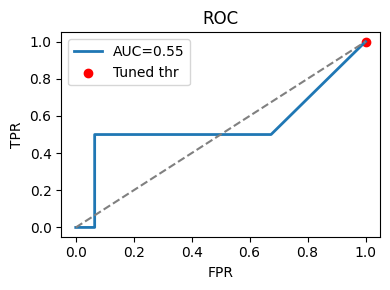

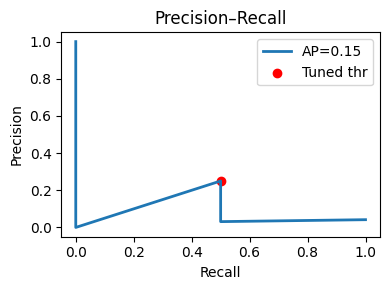

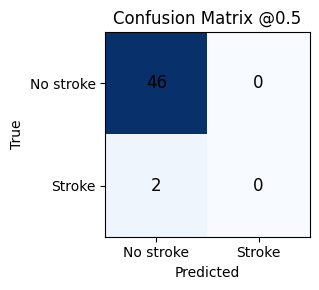

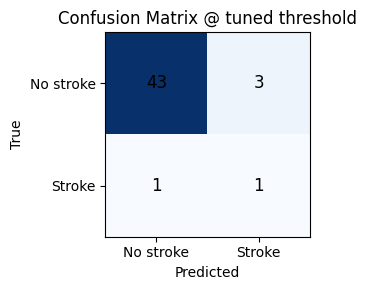

In [ ]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc, average_precision_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Use your tuned threshold variable; if it's named differently, set thr accordingly.
thr = tuned_thr if 'tuned_thr' in globals() else (final_thr if 'final_thr' in globals() else 0.5)

# ROC
fpr, tpr, roc_th = roc_curve(y_val, val_prob)
plt.figure(figsize=(4,3))
plt.plot(fpr, tpr, lw=2, label=f"AUC={auc(fpr,tpr):.2f}")
i = np.searchsorted(np.r_[roc_th,1.0], thr)
plt.scatter(fpr[min(i, len(fpr)-1)], tpr[min(i, len(tpr)-1)], c='r', label='Tuned thr')
plt.plot([0,1],[0,1],'--',c='gray'); plt.legend(); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC")
plt.tight_layout(); plt.show()

# PR
prec, rec, th = precision_recall_curve(y_val, val_prob)
plt.figure(figsize=(4,3))
plt.plot(rec, prec, lw=2, label=f"AP={average_precision_score(y_val,val_prob):.2f}")
j = np.searchsorted(np.r_[th,1.0], thr)
plt.scatter(rec[min(j, len(rec)-1)], prec[min(j, len(prec)-1)], c='r', label='Tuned thr')
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.legend(); plt.title("Precision–Recall")
plt.tight_layout(); plt.show()

# Confusion matrices @0.5 vs tuned threshold
def show_cm(y_true, y_prob, threshold, title):
    cm = confusion_matrix(y_true, (y_prob >= threshold).astype(int), labels=[0,1])
    fig, ax = plt.subplots(1,1,figsize=(3.5,3))
    ax.imshow(cm, cmap="Blues"); ax.set_title(title)
    for r in range(2):
        for c in range(2):
            ax.text(c, r, cm[r,c], va="center", ha="center", fontsize=12)
    ax.set_xticks([0,1]); ax.set_xticklabels(["No stroke","Stroke"])
    ax.set_yticks([0,1]); ax.set_yticklabels(["No stroke","Stroke"])
    ax.set_xlabel("Predicted"); ax.set_ylabel("True")
    plt.tight_layout(); plt.show()

show_cm(y_val, val_prob, 0.5, "Confusion Matrix @0.5")
show_cm(y_val, val_prob, thr,  "Confusion Matrix @ tuned threshold")

Explaining case idx=1  →  predicted stroke prob=0.140


/tmp/ipykernel_2351/3076162192.py:50: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  prob = float(model.predict_proba(x_case)[:, 1])


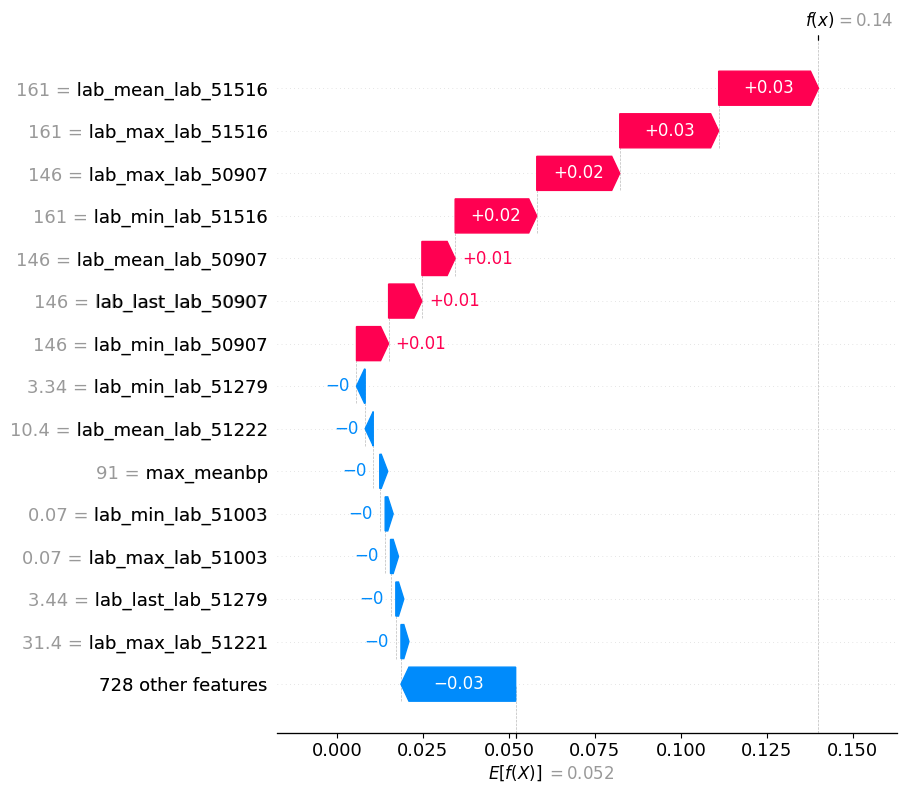

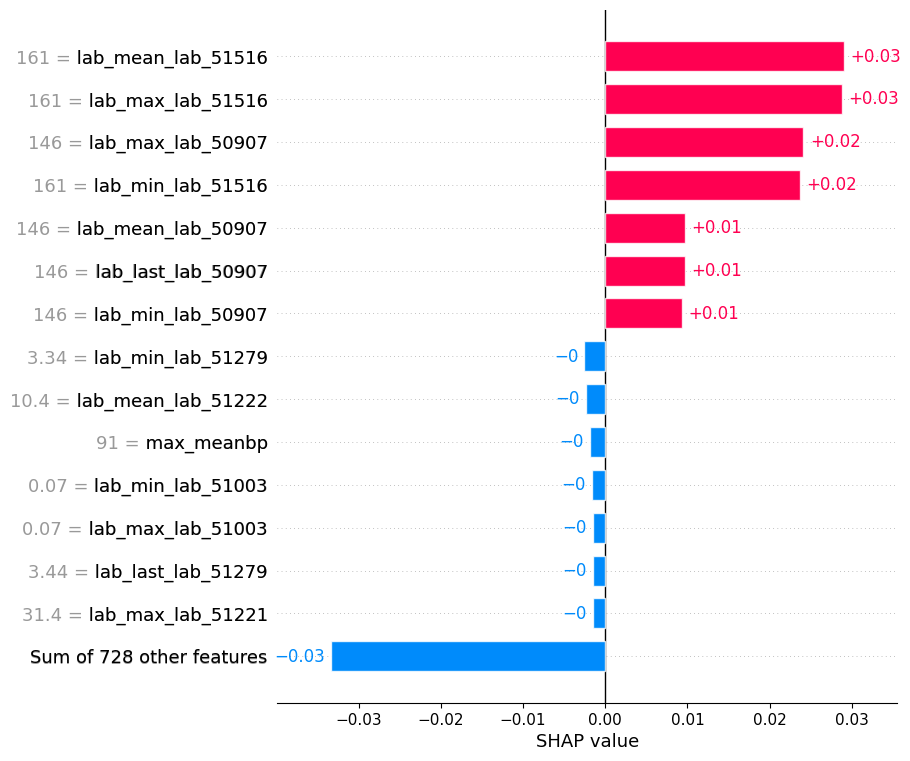

In [ ]:
import numpy as np
import shap

# 1) Build explainer once
explainer = shap.TreeExplainer(model)

# 2) Pick a case to explain: first positive if available, else first sample
idx = int(np.where(y_val == 1)[0][0]) if (y_val == 1).any() else 0
x_case = X_val.iloc[[idx]]  # keep as 1-row DataFrame

# 3) Get a single-case Explanation (not the whole val set)
exp = explainer(x_case)  # exp.values shape may be (1, n_feat) or (1, n_feat, n_out) or (n_feat, n_out), etc.

# 4) Extract a 1D SHAP vector and base value for class=1
#    Handle shapes across SHAP versions / model types
vals = exp.values          # SHAP contribution values
base = exp.base_values     # expected value(s)
data = exp.data            # feature values (same order as X_val.columns)

# Normalize shapes to (n_feat, n_out) and (n_out,) if needed
vals = np.array(vals)
base = np.array(base)
data = np.array(data)

# If we have batch dimension, drop it (we only passed 1 row)
if vals.ndim == 3 and vals.shape[0] == 1:
    vals = vals[0]        # (n_feat, n_out)
if base.ndim == 2 and base.shape[0] == 1:
    base = base[0]        # (n_out,)
if data.ndim == 2 and data.shape[0] == 1:
    data = data[0]        # (n_feat,)

# Now pick the positive class column if multi-output, else just squeeze
if vals.ndim == 2:
    # vals is (n_feat, n_out). Choose class 1 if present, else last column.
    out_idx = 1 if vals.shape[1] > 1 else 0
    sv_vec = vals[:, out_idx]
    base_val = float(base[out_idx]) if base.ndim == 1 and base.size > 1 else float(base)
elif vals.ndim == 1:
    sv_vec = vals
    base_val = float(base) if base.size == 1 else float(base[1] if base.size > 1 else base[0])
else:
    # Very old/new shapes: fallback to flatten last dim
    sv_vec = vals.squeeze()
    if sv_vec.ndim > 1:    # still not 1D
        sv_vec = sv_vec[:, -1]
    base_val = float(base.squeeze()[-1] if base.size > 1 else base.squeeze())

# 5) Show probability & case info
prob = float(model.predict_proba(x_case)[:, 1])
print(f"Explaining case idx={idx}  →  predicted stroke prob={prob:.3f}")

# 6) Waterfall (slide-friendly). Build a single-sample Explanation with 1D values
try:
    exp1 = shap.Explanation(
        values=sv_vec,
        base_values=base_val,
        data=data,
        feature_names=X_val.columns.tolist()
    )
    shap.plots.waterfall(exp1, max_display=15)
except Exception:
    # Fallback for older SHAP
    shap.plots._waterfall.waterfall_legacy(base_val, sv_vec, feature_names=X_val.columns, max_display=15)

# 7) Optional: per-case bar of top drivers
try:
    shap.plots.bar(exp1, max_display=15)
except Exception:
    pass